# Solution

Here you will find the solution for the challenge A.

Two simulations are needed, one with the barrier and one without.

In [1]:
import festim as F
import h_transport_materials as htm
import numpy as np

upstream_pressure = 1e6  # Pa (=10 bar)
barrier_thick = 2.5e-6
substrate_thick = 0.02

# eurofer properties
diffusivity_eurofer = htm.diffusivities.filter(material="eurofer_97").filter(
    author="chen"
)
D_eurofer = diffusivity_eurofer[0]

solubility_eurofer = htm.solubilities.filter(material="eurofer_97").filter(
    author="chen"
)
S_eurofer = solubility_eurofer[0]

# Al2O3 properties
diffusivity_al2o3 = (
    htm.diffusivities.filter(material="alumina")
    .filter(isotope="h")
    .filter(author="serra")
)
D_al2o3 = diffusivity_al2o3[0]
solubility_al2o3 = (
    htm.solubilities.filter(material="alumina")
    .filter(isotope="h")
    .filter(author="serra")
)
S_al2o3 = solubility_al2o3[0]

## Model with barrier

In [2]:
model_with_barrier = F.Simulation(log_level=40)

# define mesh
vertices_left = np.linspace(0, substrate_thick, num=500)

vertices_right = np.linspace(substrate_thick, substrate_thick + barrier_thick, num=500)


vertices = np.concatenate([vertices_left, vertices_right])

model_with_barrier.mesh = F.MeshFromVertices(vertices)

# define materials
eurofer = F.Material(
    id=2,
    borders=[0, substrate_thick],
    D_0=D_eurofer.pre_exp.magnitude,
    E_D=D_eurofer.act_energy.magnitude,
    S_0=S_eurofer.pre_exp.magnitude,
    E_S=S_eurofer.act_energy.magnitude,
)
al2o3 = F.Material(
    id=1,
    borders=[substrate_thick, substrate_thick + barrier_thick],
    D_0=D_al2o3.pre_exp.magnitude,
    E_D=D_al2o3.act_energy.magnitude,
    S_0=S_al2o3.pre_exp.magnitude,
    E_S=S_al2o3.act_energy.magnitude,
)
model_with_barrier.materials = [eurofer, al2o3]

# define temperature
model_with_barrier.T = 600

# define boundary conditions
model_with_barrier.boundary_conditions = [
    F.SievertsBC(
        surfaces=1, S_0=eurofer.S_0, E_S=eurofer.E_S, pressure=upstream_pressure
    ),
    F.DirichletBC(surfaces=2, value=0, field="solute"),
]

# define settings
model_with_barrier.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    transient=True,
    chemical_pot=True,
    final_time=1e5,
)

# define exports
# define exports
permeation_flux_with_barrier = F.SurfaceFlux("solute", surface=2)
model_with_barrier.exports = [
    F.DerivedQuantities([permeation_flux_with_barrier], show_units=True)
]

model_with_barrier.dt = F.Stepsize(initial_value=0.5, stepsize_change_ratio=1.1)


# run simulation
model_with_barrier.initialise()
model_with_barrier.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+05 s    Elapsed time so far: 1.1 s


# Model without barrier

In [3]:
model_without_barrier = F.Simulation(log_level=40)

# define mesh
vertices = np.linspace(0, substrate_thick, num=500)

model_without_barrier.mesh = F.MeshFromVertices(vertices)

# define materials
eurofer = F.Material(
    id=2,
    borders=[0, substrate_thick],
    D_0=D_eurofer.pre_exp.magnitude,
    E_D=D_eurofer.act_energy.magnitude,
    S_0=S_eurofer.pre_exp.magnitude,
    E_S=S_eurofer.act_energy.magnitude,
)
model_without_barrier.materials = eurofer

# define temperature
model_without_barrier.T = F.Temperature(value=600)

# define boundary conditions
model_without_barrier.boundary_conditions = [
    F.SievertsBC(
        surfaces=1, S_0=eurofer.S_0, E_S=eurofer.E_S, pressure=upstream_pressure
    ),
    F.DirichletBC(surfaces=2, value=0, field="solute"),
]

# define settings
model_without_barrier.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    transient=True,
    chemical_pot=False,
    final_time=1e5,
)

model_without_barrier.dt = F.Stepsize(initial_value=0.5, stepsize_change_ratio=1.1)

# define exports
permeation_flux_without_barrier = F.SurfaceFlux("solute", surface=2)
model_without_barrier.exports = [
    F.DerivedQuantities([permeation_flux_without_barrier], show_units=True)
]

# run simulation
model_without_barrier.initialise()
model_without_barrier.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+05 s    Elapsed time so far: 0.5 s


## Results

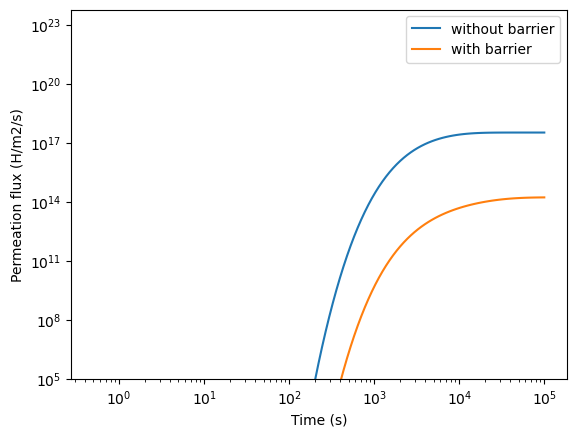

In [7]:
t_without_barrier = permeation_flux_without_barrier.t
t_with_barrier = permeation_flux_with_barrier.t

permeation_flux_with_barrier_vals = -np.array(permeation_flux_with_barrier.data)
permeation_flux_without_barrier_vals = -np.array(permeation_flux_without_barrier.data)

import matplotlib.pyplot as plt

plt.figure()

plt.plot(t_without_barrier, permeation_flux_without_barrier_vals, label="without barrier")
plt.plot(t_with_barrier, permeation_flux_with_barrier_vals, label="with barrier")

plt.xscale("log")
plt.yscale("log")
plt.ylim(bottom=1e5)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Permeation flux (H/m2/s)")
plt.show()

In [8]:
PRF = permeation_flux_without_barrier_vals[-1] / permeation_flux_with_barrier_vals[-1]

print(f"PRF: {PRF:.2e}")

PRF: 1.96e+03
